In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import Tuple


#### B-Spline Implementation:

We apply a formulation of [basis splines](https://mathworld.wolfram.com/B-Spline.html) to randomly generated data.

In [2]:
@dataclass(repr=False)
class One_Dim_BSpline:
    """One-Dimensional Basis Splines."""

    control_points: np.array

    def set_up_basis_functions(self, curve_type: str, degree: int) -> None:
        """Set up knot values and initial basis function values."""
        n = len(self.control_points) - 1
        m = degree + n + 1
        num_knots = m + 1

        self.degree = degree

        self.basis_function_0arr = np.zeros(shape=(n + 1))

        if curve_type == "non_periodic":
            # first and last p + 1 knots are null
            for i in range(self.degree + 1, m - self.degree):
                self.basis_function_0arr[i] = 1
            self.knot_array = np.zeros(num_knots)
            self.knot_array[self.degree + 1 : m - self.degree] = np.linspace(
                0, 1, m - 2 * self.degree - 1
            )
            self.knot_array[num_knots - self.degree - 1 :] = 1

        elif curve_type == "uniform":
            # all knots are non-null
            self.basis_function_0arr[:] = 1
            self.knot_array = np.linspace(0, 1, num_knots)

    def evaluate_basis_func(self, i: int, j: int, t: float) -> float:
        """Recursively evaluate basis function."""
        w1 = 0
        w2 = 0

        if j == 0:
            if self.knot_array[i] <= t and self.knot_array[i + 1] > t:
                return 1
            return 0
        elif (self.knot_array[i + j] - self.knot_array[i]) != 0:
            w1 = (
                (t - self.knot_array[i])
                / (self.knot_array[i + j] - self.knot_array[i])
                * self.evaluate_basis_func(i, j - 1, t)
            )
        if (self.knot_array[i + j + 1] - self.knot_array[i + 1]) != 0:
            w2 = (
                (self.knot_array[i + j + 1] - t)
                / (self.knot_array[i + j + 1] - self.knot_array[i + 1])
                * self.evaluate_basis_func(i + 1, j - 1, t)
            )

        return w1 + w2


#### Initial test with generated data:

Consider a set of control points defined as the image of the stochastic function

$$
f(t) = t^2 - 0.5 t - 3 + 0.05 z
$$

where $t \in \{0, 1, 2, \dots, \frac{n - 1}{n})$ and $z \sim \mathcal{N}(0, 1)$

this spline is 5-times differentiable at each non-duplicate knot.


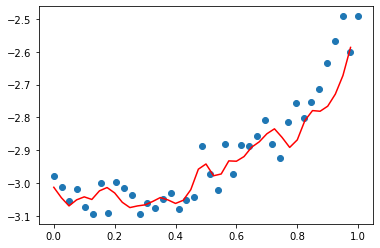

In [3]:
control_points = np.array(
    [t ** 2 - 0.5 * t - 3 + np.random.normal(scale=0.05) for t in np.linspace(0, 1, 40)]
)

bspline = One_Dim_BSpline(control_points=control_points)

bspline.set_up_basis_functions(curve_type="non_periodic", degree=5)


def eval(t, control_points, bspline):
    """Evaluate the basis spline by summing recursive evaluations."""
    result = 0
    for i in range(len(control_points)):
        result += control_points[i] * bspline.evaluate_basis_func(
            i=i, j=bspline.degree, t=t
        )
    return result


t_arr = np.linspace(0, 1, 40, endpoint=False)
print(f"this spline is {bspline.degree}-times differentiable at each non-duplicate knot.")
plt.scatter(np.linspace(0, 1, len(control_points)), control_points)
plt.plot(t_arr, [eval(t, control_points, bspline) for t in t_arr], color="r")


Now we will consider data generated by the stochastic function

$$
f(t) = (at + b) \cdot e^{-ct} + d + \sigma z
$$

Where $z \sim \mathcal{N}(0, 1)$.

Such a function is used in interest rate modeling to capture caplet volatilities as a function of the tenor.

In [4]:
def eval_vol_curve(a, b, c, d, sigma, t):
    return (a * t + b) * np.exp(-c * t) + d + np.random.normal(scale=sigma)

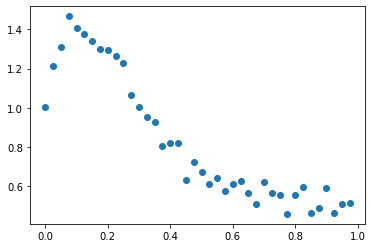

In [5]:
a = 15
b = 0.5
c = 7.5
d = 0.5
sigma = 0.05

t_arr = np.linspace(0, 1, 40, endpoint=False)

control_points = [eval_vol_curve(a, b, c, d, sigma, t) for t in t_arr]

plt.scatter(t_arr, control_points)

#### Creating a Generalized Additive Model using a Backfitting Algorithm

With this generated data, we use a backfitting algorithm defined [here](https://en.wikipedia.org/wiki/Backfitting_algorithm) to create a generalized additive model from basis splines.

In [6]:
def backfit_gam(
    control_points, num_basis_funcs, degree, niter, tol
) -> Tuple[np.ndarray, float]:
    """Iteratively backfit basis functions to produce converged GAM."""
    alpha_hat = np.mean(control_points)
    func_mat = np.zeros(shape=(num_basis_funcs, len(control_points)))
    iter_num = 0
    basis_funcs_roster = range(num_basis_funcs)
    while iter_num < niter:
        if len(basis_funcs_roster) == 0:
            break
        for j in basis_funcs_roster:

            selected_rows = np.arange(num_basis_funcs) != j
            other_func_evals = np.sum(func_mat[selected_rows, :], axis=0)

            subtracted_vals = control_points - alpha_hat - other_func_evals
            bspline = One_Dim_BSpline(control_points=subtracted_vals)
            bspline.set_up_basis_functions(curve_type="non_periodic", degree=degree)
            f_j = [eval(t, subtracted_vals, bspline) for t in t_arr]
            f_j = f_j - np.mean(f_j)
            if np.linalg.norm(f_j - func_mat[j, :], ord=2) < tol:
                basis_funcs_roster = np.delete(
                    basis_funcs_roster, np.where(basis_funcs_roster == j)
                )

                if len(basis_funcs_roster) == 0:
                    break
                continue
            else:
                func_mat[j, :] = f_j

        iter_num += 1
    return func_mat, alpha_hat


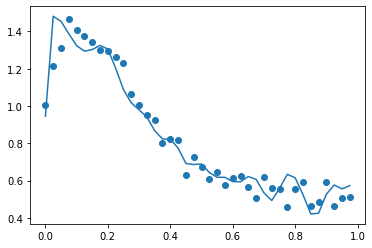

In [7]:
func_mat, alpha = backfit_gam(
    control_points, num_basis_funcs=2, degree=6, niter=100, tol=1e-6
)
plt.plot(t_arr, np.sum(func_mat, axis=0) + alpha)
plt.scatter(t_arr, control_points)
